In [17]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
import torchvision
import torchvision.models as models


In [3]:
query_path_dir = './data/query'
text_path_dir = './data/query_txt'
gallery_path_dir = './data/gallery'

save_cropped_query_dir = './data/cropped_query'
save_gallery_feat_dir = './data/gallery_feature'
save_query_feat_dir = './data/query_feature'

## Cropping the queries

In [3]:
# First change color of queries to RGB, then crop the querry.

images = []
for filename in os.listdir(query_path_dir):

    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        
        img = cv2.imread(os.path.join(query_path_dir,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_path = ''
        save_path = ''

        img_path = filename.split('.')[0] + '.txt'
        txt = np.loadtxt(text_path_dir + '/'+ img_path);

        crop = img[int(txt[1]):int(txt[1] + txt[3]), int(txt[0]):int(txt[0] + txt[2]), :]
    
        #final_img = cv2.resize(crop, (224, 224), interpolation=cv2.INTER_CUBIC)

        save_path = save_cropped_query_dir + '/'+ filename
        cv2.imwrite(save_path, crop)  

## Extracting Gallery Features

In [4]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# resize the image to desired size
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for filename in os.listdir(gallery_path_dir):

    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        
        img = cv2.imread(os.path.join(gallery_path_dir,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)


        t_img = transforms(img)
        features = torch.zeros(512)

        def copy_data(m, i, o):
            features.copy_(o.flatten())

        h = layer.register_forward_hook(copy_data)
            
        with torch.no_grad():                              
            model(t_img.unsqueeze(0))

        h.remove()

        savefilename = save_gallery_feat_dir + '/' + filename.split('.')[0] + '.pt'

        torch.save(features, savefilename)



/Users/fahadkhan/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/fahadkhan/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Extracting Query Features

In [5]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# resize the image to desired size
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for filename in os.listdir(save_cropped_query_dir):

    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        
        img = cv2.imread(os.path.join(save_cropped_query_dir,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)


        t_img = transforms(img)
        features = torch.zeros(512)

        def copy_data(m, i, o):
            features.copy_(o.flatten())

        h = layer.register_forward_hook(copy_data)
            
        with torch.no_grad():                              
            model(t_img.unsqueeze(0))

        h.remove()

        savefilename = save_query_feat_dir + '/' + filename.split('.')[0] + '.pt'

        torch.save(features, savefilename)

## Comparing the query and gallery features and saving in text file

In [25]:
# open file for writing
f = open("ResNet_RankList_5000.txt","w")

for filename1 in os.listdir(save_query_feat_dir):
    if filename1.endswith('.pt'):
        pic_one_vector  = torch.load(os.path.join(save_query_feat_dir, filename1))
    
        dict1 = {}

        for filename2 in os.listdir(save_gallery_feat_dir):

            if filename2.endswith('.pt'):
        
                pic_two_vector  = torch.load(os.path.join(save_gallery_feat_dir, filename2))

                # Using PyTorch Cosine Similarity
                cos = nn.CosineSimilarity(dim=1, eps=1e-6)
                cos_sim = cos(pic_one_vector.unsqueeze(0), pic_two_vector.unsqueeze(0))
            
                gallery_idx = filename2.split('.')[0] + '.jpg'
                dict1[gallery_idx] = cos_sim
        
        sorted_dict = sorted(dict1.items(), key=lambda item: item[1], reverse=True) # Sort the similarity score

        f.write('Q' + filename1.split('.')[0] + " : ")
        for tup in sorted_dict:
            key = str(tup[0]).split('.')[0]
            f.write( key + ", ")
        f.write("\n")
        f.write("\n")

f.close()


### Text output for the 10 best only.

In [26]:
# open file for writing
f = open("ResNet_RankList_10.txt","w")

for filename1 in os.listdir(save_query_feat_dir):
    if filename1.endswith('.pt'):
        pic_one_vector  = torch.load(os.path.join(save_query_feat_dir, filename1))
    
        dict1 = {}

        for filename2 in os.listdir(save_gallery_feat_dir):

            if filename2.endswith('.pt'):
        
                pic_two_vector  = torch.load(os.path.join(save_gallery_feat_dir, filename2))

                # Using PyTorch Cosine Similarity
                cos = nn.CosineSimilarity(dim=1, eps=1e-6)
                cos_sim = cos(pic_one_vector.unsqueeze(0), pic_two_vector.unsqueeze(0))
            
                gallery_idx = filename2.split('.')[0] + '.jpg'
                dict1[gallery_idx] = cos_sim
        
        sorted_dict = sorted(dict1.items(), key=lambda item: item[1], reverse=True) # Sort the similarity score
        best_10 = sorted_dict[0: 10]

        f.write('Q' + filename1.split('.')[0] + " : ")
        for tup in best_10:
            key = str(tup[0]).split('.')[0]
            f.write( key + ", ")
        f.write("\n")

f.close()

# Displaying Result For A Single Query

### Using cosine similarity

In [20]:
pic_one_vector  = torch.load(os.path.join(save_query_feat_dir, '4354.pt'))

dict1 = {}

for filename2 in os.listdir(save_gallery_feat_dir):

    if filename2.endswith('.pt'):
        
        pic_two_vector  = torch.load(os.path.join(save_gallery_feat_dir, filename2))

        # Using PyTorch Cosine Similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        cos_sim = cos(pic_one_vector.unsqueeze(0), pic_two_vector.unsqueeze(0))
            
        gallery_idx = filename2.split('.')[0] + '.jpg'
        dict1[gallery_idx] = cos_sim
        
sorted_dict = sorted(dict1.items(), key=lambda item: item[1],reverse=True) # Sort the similarity score
best_10 = sorted_dict[0: 10]

print(best_10)


[('2.jpg', tensor([0.8578])), ('19.jpg', tensor([0.7892])), ('2673.jpg', tensor([0.7656])), ('1485.jpg', tensor([0.7476])), ('3529.jpg', tensor([0.7465])), ('2666.jpg', tensor([0.7443])), ('3850.jpg', tensor([0.7428])), ('613.jpg', tensor([0.7388])), ('1690.jpg', tensor([0.7355])), ('4090.jpg', tensor([0.7343]))]


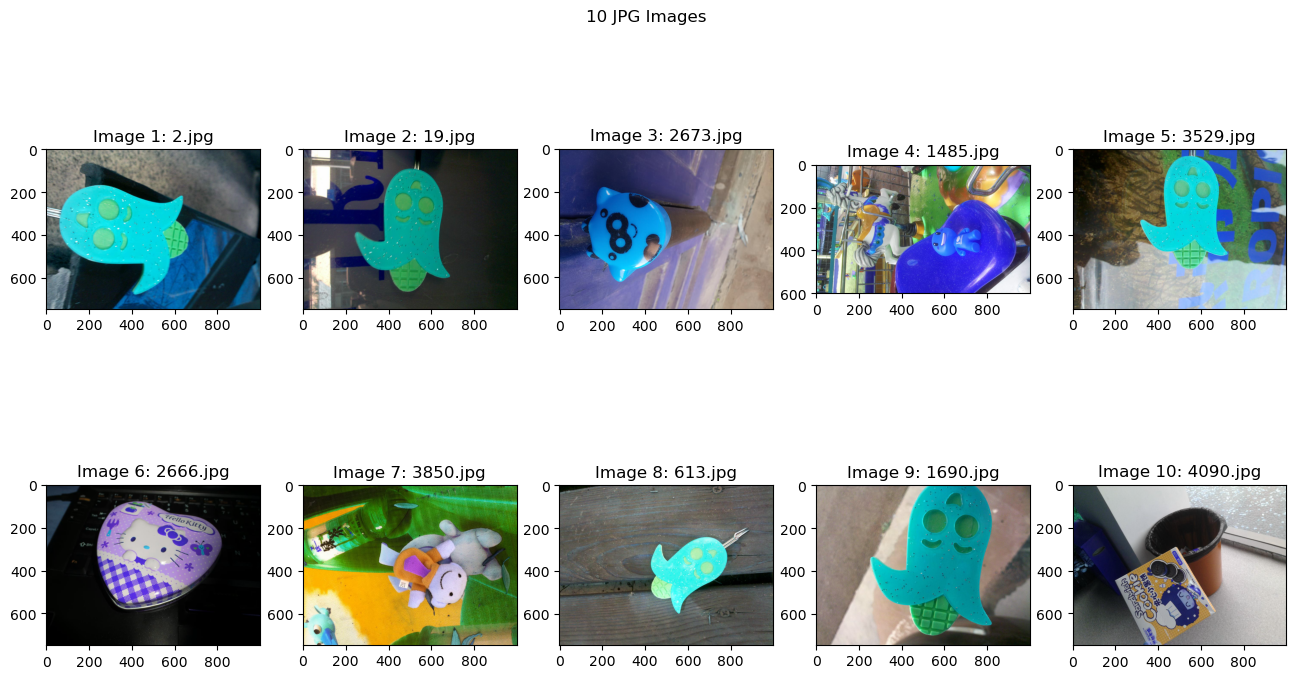

In [21]:
images = []
#images.append(cv2.imread(os.path.join(query_path_dir, '35.jpg')))

for tup in best_10:
    images.append(cv2.imread(os.path.join(gallery_path_dir, str(tup[0]))))


fig, axs = plt.subplots(2, 5, figsize=(16, 8))
fig.suptitle('10 JPG Images')

# Display the images in the subplots
for i in range(10):
    ax = axs[i // 5][i % 5]
    ax.imshow(images[i])
    ax.set_title(f'Image {i+1}: ' + best_10[i][0])

# Show the figure
plt.show()

### Using equlidean distance

In [14]:
pic_one_vector  = torch.load(os.path.join(save_query_feat_dir, '27.pt'))

dict1 = {}

for filename2 in os.listdir(save_gallery_feat_dir):

    if filename2.endswith('.pt'):
        
        pic_two_vector  = torch.load(os.path.join(save_gallery_feat_dir, filename2))

        # Using PyTorch Cosine Similarity
        #cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        #cos_sim = cos(pic_one_vector.unsqueeze(0), pic_two_vector.unsqueeze(0))

        euclidena_dist = sum(((pic_one_vector - pic_two_vector)**2).reshape(512)).item()
            
        gallery_idx = filename2.split('.')[0] + '.jpg'
        dict1[gallery_idx] = euclidena_dist
        
sorted_dict = sorted(dict1.items(), key=lambda item: item[1]) # Sort the similarity score
best_10 = sorted_dict[0:10]

print(best_10)

[('3035.jpg', 347.56549072265625), ('3575.jpg', 350.8659973144531), ('2997.jpg', 365.4435119628906), ('2916.jpg', 375.6371154785156), ('2765.jpg', 381.8811340332031), ('2444.jpg', 383.4880676269531), ('513.jpg', 384.8639831542969), ('4125.jpg', 390.4222106933594), ('4760.jpg', 392.03778076171875), ('1785.jpg', 393.1210632324219)]


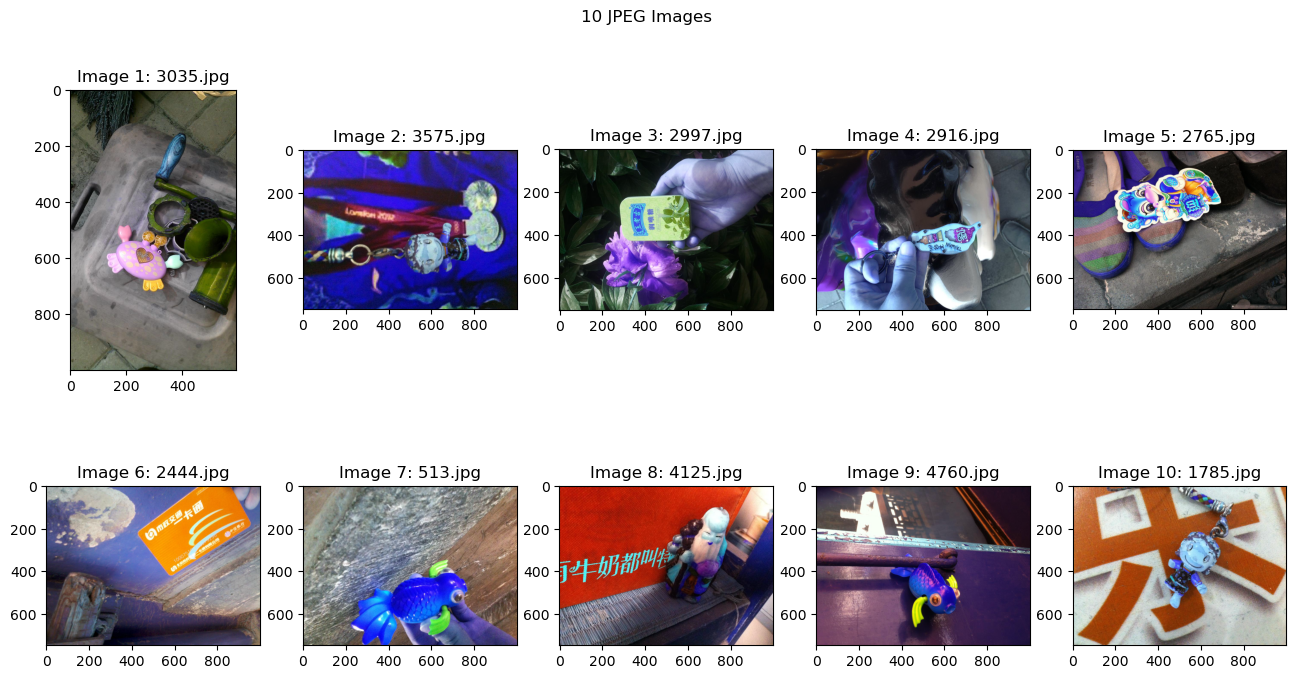

In [15]:
images = []
#images.append(cv2.imread(os.path.join(query_path_dir, '35.jpg')))

for tup in best_10:
    images.append(cv2.imread(os.path.join(gallery_path_dir, str(tup[0]))))


fig, axs = plt.subplots(2, 5, figsize=(16, 8))
fig.suptitle('10 JPEG Images')

# Display the images in the subplots
for i in range(10):
    ax = axs[i // 5][i % 5]
    ax.imshow(images[i])
    ax.set_title(f'Image {i+1}: ' + best_10[i][0])

# Show the figure
plt.show()